# Import Library & Load data

In [1]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
img = cv.imread("dataset\jerry_seinfeld\httpswwwticketscomuploadsartistsjerryseinfeldbilletsjpg.jpg")
# opencv BGR channel format and plt reads images as RGB channel format

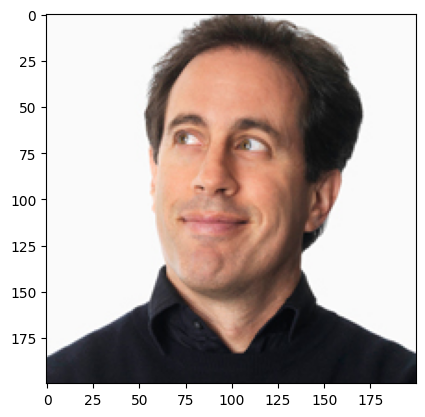

In [3]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB 

In [4]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 145ms/step


In [5]:
results

[{'box': [57, 22, 83, 118],
  'confidence': 0.9999992847442627,
  'keypoints': {'left_eye': (74, 66),
   'right_eye': (111, 71),
   'nose': (87, 91),
   'mouth_left': (72, 110),
   'mouth_right': (106, 113)}}]

In [6]:
x,y,w,h = results[0]['box']

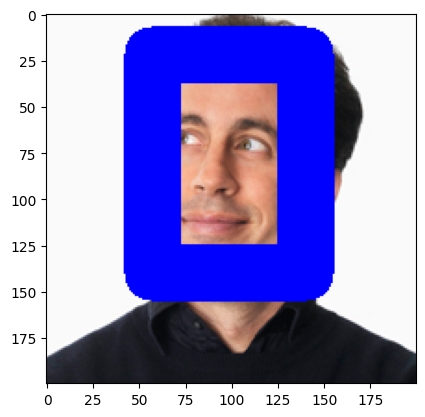

In [7]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

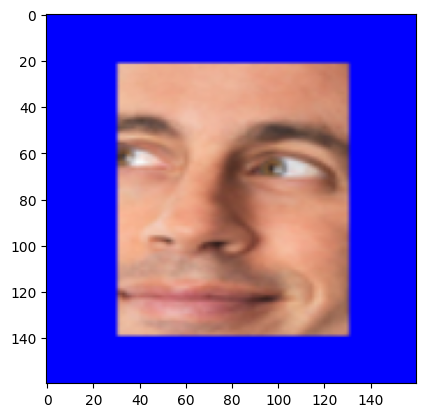

In [8]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160 
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [9]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

# Automate the preprocessing 

In [10]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [11]:
faceloading = FACELOADING("dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 26ms/step
Loaded successfully: 19
1/1 [==============================] - 0s 23ms/step
Loaded successfully: 22
1/1 [==============================] - 0s 26ms/step
Loaded successfully: 26
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 24
1/1 [==============================] - 0s 27ms/step
Loaded successfully: 27


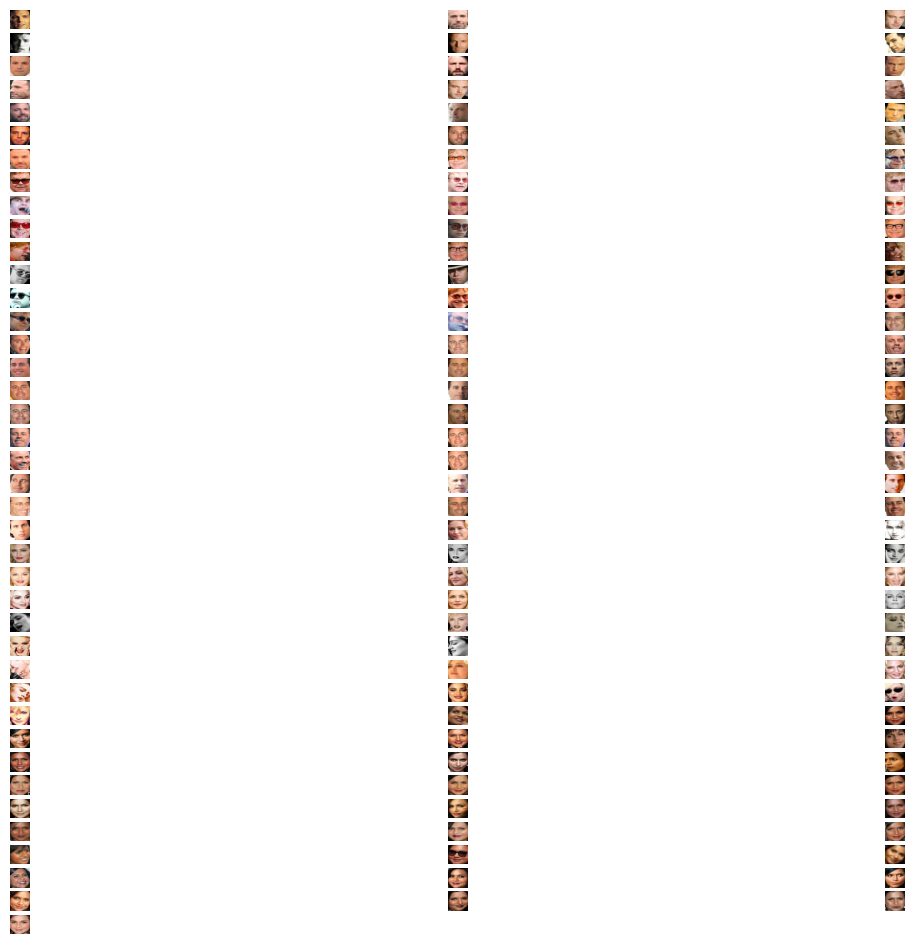

In [12]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet

In [13]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [14]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 74ms/step


In [15]:
np.savez_compressed('faces_embeddings_done_5classes.npz', EMBEDDED_X, Y)

# SVM Model

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

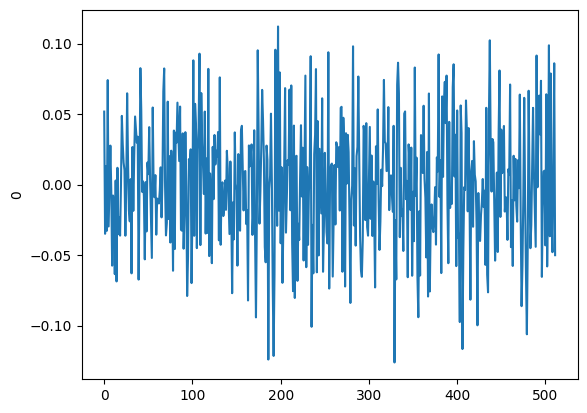

In [17]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [18]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [20]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

Training Accuracy: 1.0
Test Accuracy: 1.0
Confusion Matrix - Training Set
[[14  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 22]]
Confusion Matrix - Test Set
[[5 0 0 0 0]
 [0 4 0 0 0]
 [0 0 8 0 0]
 [0 0 0 8 0]
 [0 0 0 0 5]]


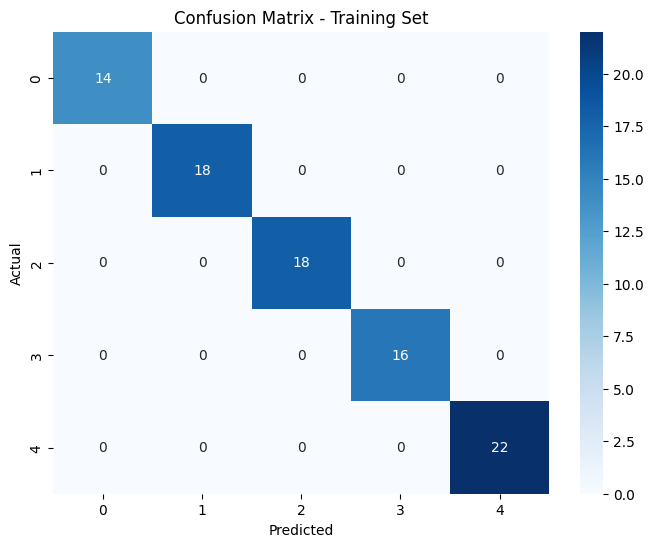

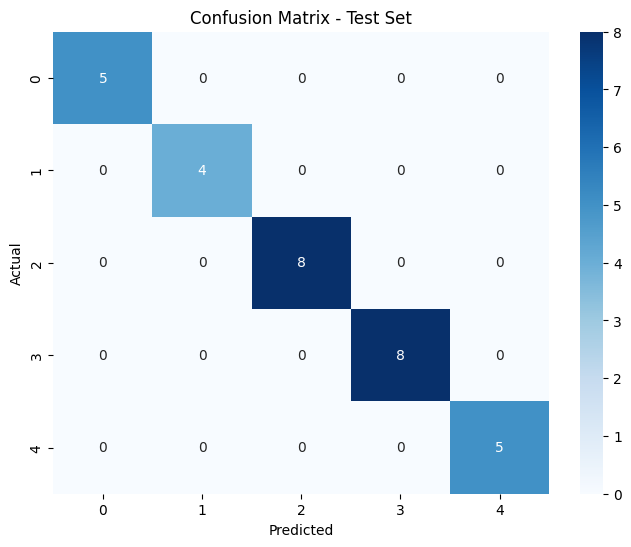

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Calculating accuracy
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

train_accuracy = accuracy_score(Y_train, ypreds_train)
test_accuracy = accuracy_score(Y_test, ypreds_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Confusion matrix for training set
conf_matrix_train = confusion_matrix(Y_train, ypreds_train)
print('Confusion Matrix - Training Set')
print(conf_matrix_train)

# Confusion matrix for test set
conf_matrix_test = confusion_matrix(Y_test, ypreds_test)
print('Confusion Matrix - Test Set')
print(conf_matrix_test)

# Visualizing confusion matrix using seaborn heatmap
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Training Set')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Set')

In [22]:
t_im = cv.imread("dataset/jerry_seinfeld\httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIwNjANjMMDINzIxNjcjpg.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 26ms/step


In [23]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 89ms/step


In [24]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [25]:
ypreds

array([2])

In [26]:
encoder.inverse_transform(ypreds)

array(['jerry_seinfeld'], dtype='<U14')

In [27]:
import pickle
#save the model
with open('UD_facenet_svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)